In [1]:
import os
import glob
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from PIL import Image


In [14]:

# Function to one-hot encode the mask for multi-class segmentation
def one_hot_encode(mask, num_classes=4):
    one_hot = tf.one_hot(tf.squeeze(tf.cast(mask, tf.int32)), depth=num_classes)
    return one_hot


def load_and_preprocess(image_path, mask_path, target_size=(288, 288), augment=False):
    image = load_img(image_path, color_mode='grayscale')
    mask = load_img(mask_path, color_mode='grayscale')
    
    image = image.resize(target_size)
    mask = mask.resize(target_size)
    
    image = img_to_array(image) / 255.0
    mask = img_to_array(mask)
    
    # One-hot encode the mask
    mask = one_hot_encode(mask)

    if augment:
        # Apply augmentation only to the image, not the mask
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_brightness(image, max_delta=0.2)

        # Apply the same random flips to the mask
        mask = tf.image.random_flip_left_right(mask)
        mask = tf.image.random_flip_up_down(mask)
    
    return image, mask


# Function to create a TensorFlow dataset from image and mask paths
def create_dataset(image_paths, mask_paths, batch_size, augment=False):
    def generator():
        for img_path, msk_path in zip(image_paths, mask_paths):
            yield load_and_preprocess(img_path, msk_path, augment=augment)
    
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(288, 288, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(288, 288, 4), dtype=tf.float32)
        )
    )
    return dataset.shuffle(buffer_size=len(image_paths)).batch(batch_size)

# Function to get image and mask paths
def get_paths(data_dir, image_folder='images', mask_folder='masks'):
    image_paths = glob.glob(os.path.join(data_dir, image_folder, '*.png'))
    mask_paths = [path.replace(image_folder, mask_folder) for path in image_paths]
    return image_paths, mask_paths



import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [288, 288])
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [288, 288])
    
    return image, mask

def display_image_and_mask(image, mask):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(image.numpy().squeeze(), cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('Mask')
    plt.imshow(mask.numpy().squeeze(), cmap='gray')
    plt.axis('off')
    
    plt.show()


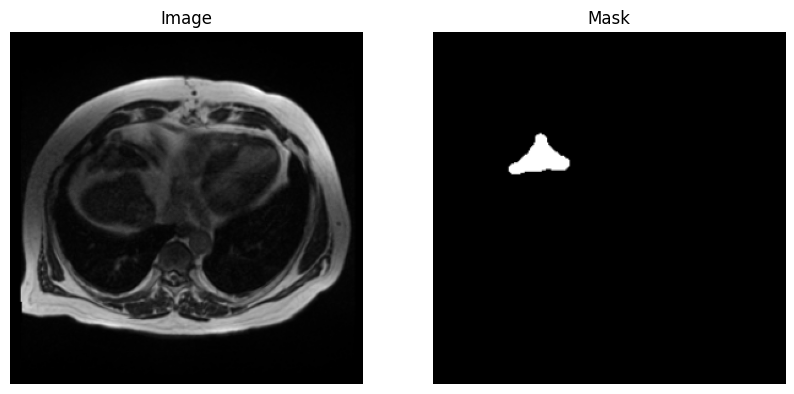

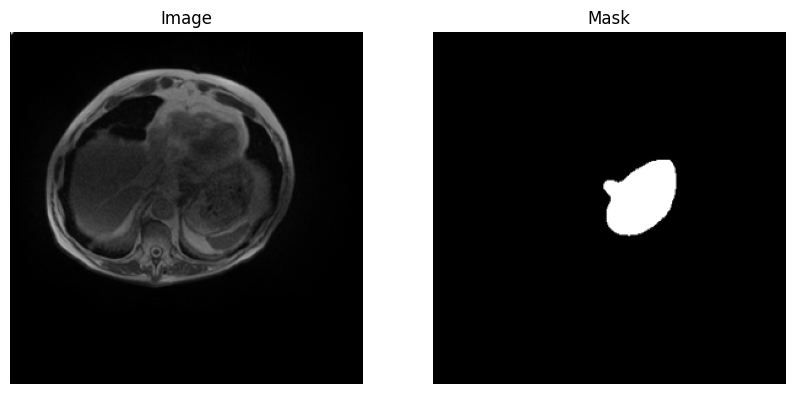

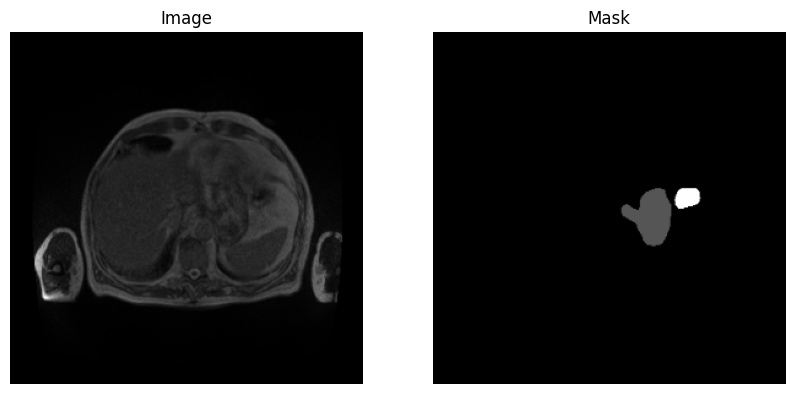

    883/Unknown - 8812s 10s/step - loss: 0.1934 - accuracy: 0.9583
Epoch 1: val_loss improved from inf to 0.16559, saving model to model_checkpoint.h5
883/883 [==============================] - 9252s 10s/step - loss: 0.1934 - accuracy: 0.9583 - val_loss: 0.1656 - val_accuracy: 0.9588


c:\Users\rahjo\anaconda3\envs\.com_conda\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
import os
import glob
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from PIL import Image
import random

tf.config.list_physical_devices('GPU')

if __name__ == "__main__":
    data_dir = 'C:/Users/rahjo/Downloads/Medical_image/dataset_UWM_GI_Tract_train_valid/train'
    image_paths, mask_paths = get_paths(data_dir)
    
    # Randomly select three images and masks
    indices = random.sample(range(len(image_paths)), 3)
    selected_image_paths = [image_paths[i] for i in indices]
    selected_mask_paths = [mask_paths[i] for i in indices]
    
    for img_path, mask_path in zip(selected_image_paths, selected_mask_paths):
        image, mask = load_and_preprocess_image(img_path, mask_path)
        display_image_and_mask(image, mask)

    train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
        image_paths, mask_paths, test_size=0.2, random_state=42
    )

    batch_size = 12
    train_dataset = create_dataset(train_image_paths, train_mask_paths, batch_size, augment=True)
    val_dataset = create_dataset(val_image_paths, val_mask_paths, batch_size)

    # Define the input shape and input layer
    input_shape = (288, 288, 1)
    inputs = Input(shape=input_shape)

    # Define the U-Net architecture
    # Downsampling path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Upsampling path
    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    # Output layer
    outputs = Conv2D(4, (1, 1), activation='softmax', padding='same')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    #model.summary()

    # Define the checkpoint callback
    checkpoint_path = "model_checkpoint.h5"
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    # Number of epochs
    epochs = 1  # This should be adjusted based on the early stopping or observed convergence

    # Train the model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        verbose=1,  # Here's where you set the verbosity
        callbacks=[checkpoint]
    )


In [4]:
#model.save('Unet_1.h5')

c:\Users\rahjo\anaconda3\envs\.com_conda\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
assert(2 == 1)

In [16]:
# Define a Function to Load and Preprocess the Image

from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess_inference(image_path, target_size=(288, 288)):
    # Load the image
    image = load_img(image_path, color_mode='grayscale')
    image = image.resize(target_size)
    image = img_to_array(image) / 255.0  # Normalize to [0, 1]

    # Expand dimensions to add batch size of 1 at the beginning
    image = np.expand_dims(image, axis=0)  # Shape becomes (1, height, width, 1)
    return image


In [17]:
# Load the Trained Model and Predict

from tensorflow.keras.models import load_model

# Load the model
model = load_model('model_checkpoint.h5')

# Load and preprocess the image
image_path = 'C:/Users/rahjo/Downloads/Medical_image/dataset_UWM_GI_Tract_train_valid/valid/images/case9_day22_slice_0094_360_310_1.50_1.50.png'
image = load_and_preprocess_inference(image_path)

# Predict the mask
predicted_mask = model.predict(image)  # Output shape: (1, height, width, num_classes)
predicted_mask = np.argmax(predicted_mask, axis=-1)  # Take argmax to find class label for each pixel
predicted_mask = predicted_mask[0]  # Remove batch dimension, shape: (height, width)


1/1 [==============================] - 0s 275ms/step


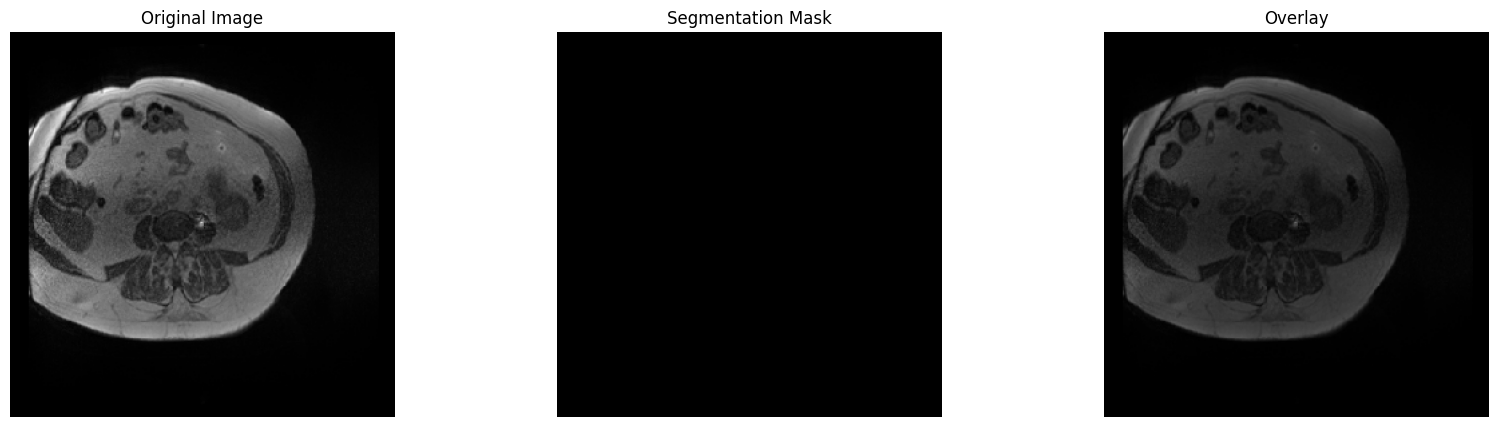

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def visualize_results(original_image, predicted_mask):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Create a colormap with numeric RGBA values
    cmap = ListedColormap([
        [0, 0, 0],       # black
        [1, 0, 0],       # red
        [0, 1, 0],       # green
        [0, 0, 1]        # blue
    ])

    # Display the original image
    axes[0].imshow(original_image, cmap='gray')
    axes[0].title.set_text('Original Image')
    axes[0].axis('off')

    # Display the mask
    axes[1].imshow(predicted_mask, cmap=cmap)
    axes[1].title.set_text('Segmentation Mask')
    axes[1].axis('off')

    # Create and display the overlay
    overlay = np.stack([original_image]*3, axis=-1)  # Convert grayscale to RGB
    for i in range(4):  # Assuming 4 classes including background
        mask = predicted_mask == i
        overlay[mask] = overlay[mask] * 0.5 + np.array(cmap.colors[i]) * 0.5

    axes[2].imshow(overlay)
    axes[2].title.set_text('Overlay')
    axes[2].axis('off')

    plt.show()

# Use the visualize function
original_image = np.squeeze(load_img(image_path, color_mode='grayscale', target_size=(288, 288)))
visualize_results(original_image, predicted_mask)
